# Day3.2 Deep Learning

### 실습 목표
- 딥러닝에서 고려해야 할 사항들이 PyTorch 상에서 어떻게 구현되는지 확인
  - Gradient Vanishing (Sigmoid vs ReLU)
  - Regularization (Dropout)
  - Mini-Batch Gradient Descent
  - Momentum & Adam
  - Batch Normalization

## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU



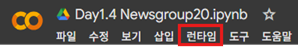

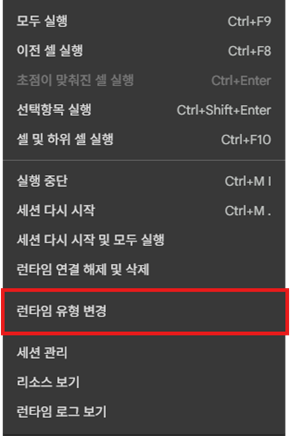

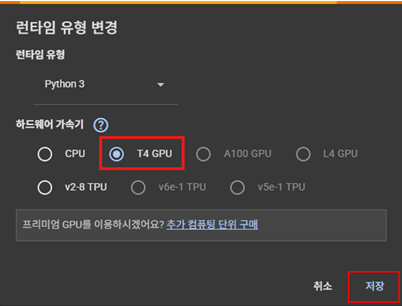

- 필요한 라이브러리 설치 및 호출

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Subset

- GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## 1. Gradient Vanishing

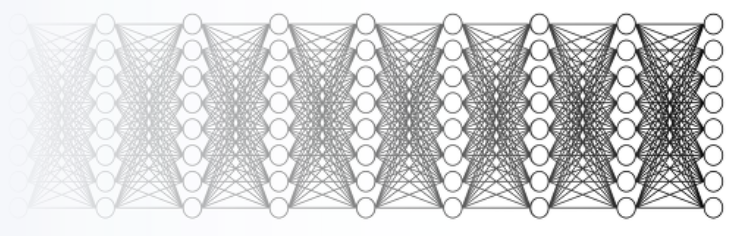

- Gradient Vanishing은 Neural Network의 layer 수가 많아질수록, 입력에 가까운 레이어에서 gradient가 거의 0에 가까워지는 현상

- 그 이유는, 역전파 과정에서 activation 함수의 미분값이 계속 곱해지며 작아지기 때문

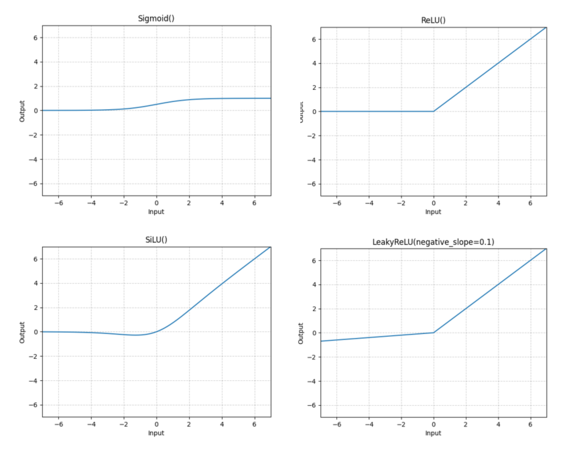


- Activation Function
  - Sigmoid는 미분했을 때 항상 0과 0.25 사이의 작은 값을 가지므로, layer가 많아질수록 gradient가 점점 작아져 입력층 근처에서는 거의 사라지게 됨
  - ReLU는 미분 시 0 또는 1의 값을 가지기 때문에, 미분값이 1인 경우에는 gradient가 잘 전달되어 깊은 층에서도 소실되지 않음
    - 그러나 ReLU의 미분값이 0이라면 Gradient가 0이 되는 Knockout 문제(Dead Neuron)가 생길 수 있음
    - 이를 방지하기 위해 LeakyReLU 나 SiLU Activation 함수를 사용되기도 함
      - `nn.LeakyRELU()`, `nn.SiLU()`
    - 그러나 Knockout 문제가 심하지 않은 이상 서로 큰 성능 차이가 없으며 일반적으로 ReLU가 좋은 성능을 보이는 경우가 많음

- Sigmoid vs ReLU

In [4]:
# 1. MNIST 로딩
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]


Training Sigmoid Model...


Epoch 1: 100%|██████████| 938/938 [00:09<00:00, 98.79it/s]


Epoch 1: Loss = 2.3031, Accuracy = 10.28%


Epoch 2: 100%|██████████| 938/938 [00:08<00:00, 110.56it/s]


Epoch 2: Loss = 2.3023, Accuracy = 10.09%


Epoch 3: 100%|██████████| 938/938 [00:08<00:00, 108.90it/s]


Epoch 3: Loss = 2.3021, Accuracy = 11.35%

Training ReLU Model...


Epoch 1: 100%|██████████| 938/938 [00:09<00:00, 97.86it/s]


Epoch 1: Loss = 2.1456, Accuracy = 63.26%


Epoch 2: 100%|██████████| 938/938 [00:09<00:00, 97.45it/s] 


Epoch 2: Loss = 0.8219, Accuracy = 84.78%


Epoch 3: 100%|██████████| 938/938 [00:14<00:00, 63.63it/s] 


Epoch 3: Loss = 0.4452, Accuracy = 88.96%


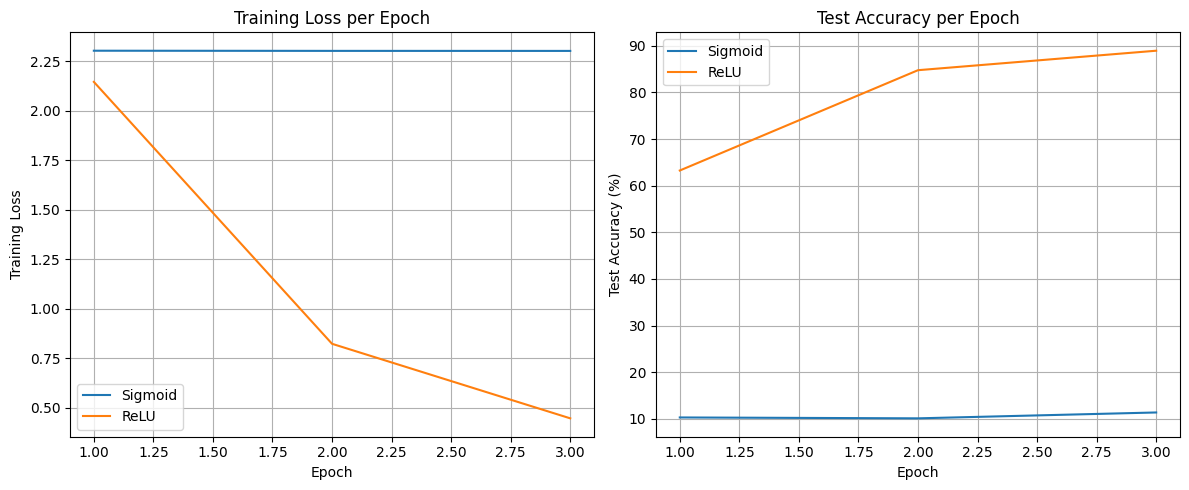

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# 1. 데이터 로더
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. 모델 정의 및 생성
class DeepNet(nn.Module):
    def __init__(self, activation_fn):
        super(DeepNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            activation_fn,
            nn.Linear(512, 256),
            activation_fn,
            nn.Linear(256, 128),
            activation_fn,
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

model_sigmoid = DeepNet(nn.Sigmoid())
model_relu = DeepNet(nn.ReLU())

# 3. 모델 학습 준비
loss_function = nn.CrossEntropyLoss()
optimizer_sigmoid = torch.optim.SGD(model_sigmoid.parameters(), lr=0.01)
optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=0.01)

# 4. 학습 및 평가 함수
def train_and_evaluate(model, optimizer, train_loader, test_loader, epochs=3):
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 평가
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        test_accuracies.append(acc)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    return train_losses, test_accuracies

# 5. 학습 실행
set_seed(0)
print("Training Sigmoid Model...")
loss_sigmoid, acc_sigmoid = train_and_evaluate(model_sigmoid, optimizer_sigmoid, train_loader, test_loader)

print("\nTraining ReLU Model...")
loss_relu, acc_relu = train_and_evaluate(model_relu, optimizer_relu, train_loader, test_loader)

# 6. 시각화
epochs = range(1, len(loss_sigmoid)+1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_sigmoid, label='Sigmoid')
plt.plot(epochs, loss_relu, label='ReLU')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_sigmoid, label='Sigmoid')
plt.plot(epochs, acc_relu, label='ReLU')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- ReLU vs LeakyReLU vs SiLU


Training model with ReLU activation...


Epoch 1: 100%|██████████| 938/938 [00:09<00:00, 103.76it/s]


Epoch 1 | Loss: 2.1540 | Accuracy: 52.93%


Epoch 2: 100%|██████████| 938/938 [00:09<00:00, 100.80it/s]


Epoch 2 | Loss: 0.8684 | Accuracy: 85.32%


Epoch 3: 100%|██████████| 938/938 [00:09<00:00, 102.02it/s]


Epoch 3 | Loss: 0.4413 | Accuracy: 88.82%


Epoch 4: 100%|██████████| 938/938 [00:09<00:00, 101.74it/s]


Epoch 4 | Loss: 0.3592 | Accuracy: 90.51%


Epoch 5: 100%|██████████| 938/938 [00:09<00:00, 101.86it/s]


Epoch 5 | Loss: 0.3177 | Accuracy: 91.53%

Training model with LeakyReLU activation...


Epoch 1: 100%|██████████| 938/938 [00:08<00:00, 113.37it/s]


Epoch 1 | Loss: 2.0967 | Accuracy: 70.58%


Epoch 2: 100%|██████████| 938/938 [00:08<00:00, 104.25it/s]


Epoch 2 | Loss: 0.7217 | Accuracy: 86.04%


Epoch 3: 100%|██████████| 938/938 [00:08<00:00, 105.56it/s]


Epoch 3 | Loss: 0.4344 | Accuracy: 89.07%


Epoch 4: 100%|██████████| 938/938 [00:08<00:00, 105.47it/s]


Epoch 4 | Loss: 0.3671 | Accuracy: 90.24%


Epoch 5: 100%|██████████| 938/938 [00:08<00:00, 111.12it/s]


Epoch 5 | Loss: 0.3236 | Accuracy: 91.44%

Training model with SiLU activation...


Epoch 1: 100%|██████████| 938/938 [00:08<00:00, 113.96it/s]


Epoch 1 | Loss: 2.2951 | Accuracy: 21.18%


Epoch 2: 100%|██████████| 938/938 [00:08<00:00, 104.59it/s]


Epoch 2 | Loss: 2.2659 | Accuracy: 32.72%


Epoch 3: 100%|██████████| 938/938 [00:08<00:00, 104.35it/s]


Epoch 3 | Loss: 2.0222 | Accuracy: 51.50%


Epoch 4: 100%|██████████| 938/938 [00:08<00:00, 105.07it/s]


Epoch 4 | Loss: 0.9943 | Accuracy: 81.85%


Epoch 5: 100%|██████████| 938/938 [00:08<00:00, 109.34it/s]


Epoch 5 | Loss: 0.5291 | Accuracy: 86.79%


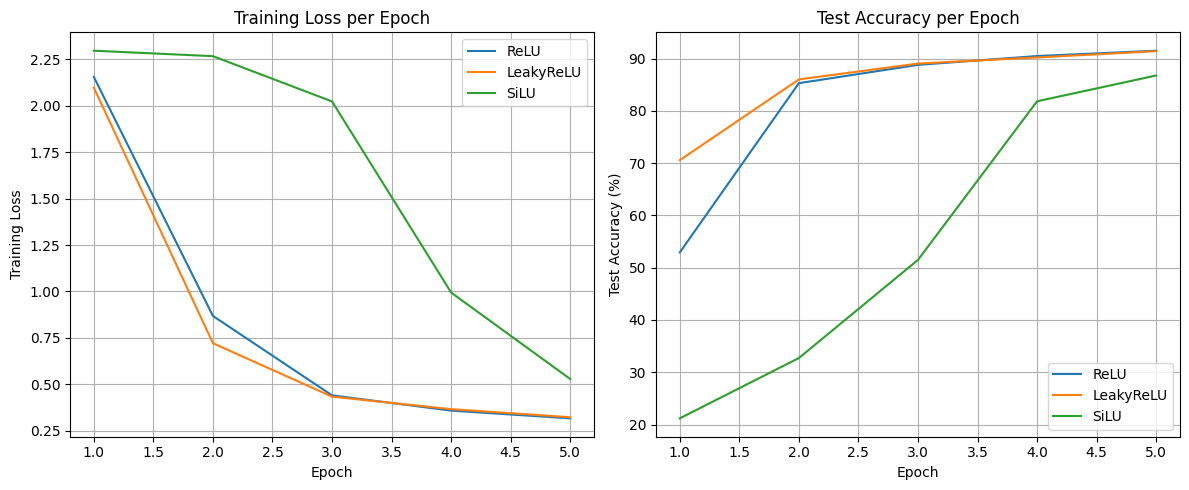

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# 데이터 로더
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 정의
class DeepNet(nn.Module):
    def __init__(self, activation_fn):
        super(DeepNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            activation_fn,
            nn.Linear(512, 256),
            activation_fn,
            nn.Linear(256, 128),
            activation_fn,
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

# 학습 함수
def train_and_evaluate(model, optimizer, train_loader, test_loader, epochs=5):
    loss_fn = nn.CrossEntropyLoss()
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # 평가
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1} | Loss: {train_losses[-1]:.4f} | Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

# 활성화 함수 설정
set_seed(42)
activations = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(0.1),
    "SiLU": nn.SiLU()
}

results = {}

# 모델 학습 실행
for name, act_fn in activations.items():
    print(f"\nTraining model with {name} activation...")
    model = DeepNet(act_fn)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_list, acc_list = train_and_evaluate(model, optimizer, train_loader, test_loader, epochs=5)
    results[name] = {"loss": loss_list, "acc": acc_list}

# 시각화
epochs = range(1, 6)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(epochs, results[name]["loss"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
for name in results:
    plt.plot(epochs, results[name]["acc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

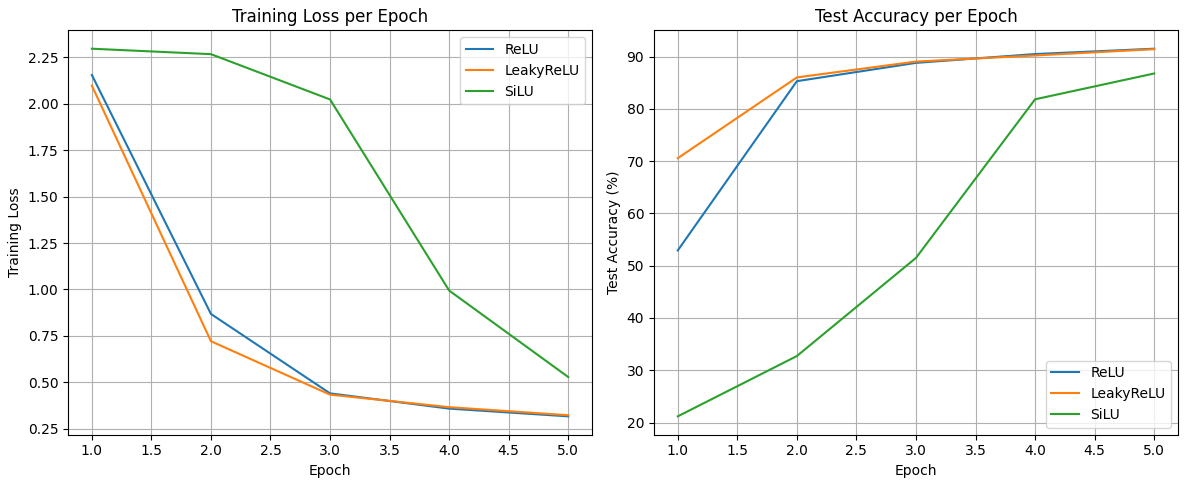

## 2. Regularization (Dropout)

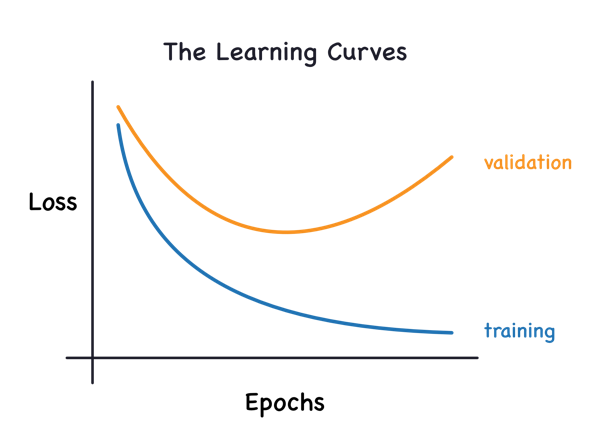

- **Overfitting** : 모델이 학습 데이터를 너무 과하게 학습하여, 새로운 테스트 데이터가 들어오면 제대로 예측하지 못하여 성능이 저하되는 현상

- Overfitting이 발생하면 Train Loss는 감소하지만, Test Loss는 오히려 증가함

- 대표적인 Overfitting의 원인들
  - 데이터 수가 부족함
  - 모델의 학습 횟수가 너무 많음
  - 모델의 구조가 너무 복잡함

- Overfitting 확인하기

In [7]:
# Overfitting을 조금 더 쉽게 확인하기 위한 작은 데이터 셋 구축
small_train_dataset = Subset(train_dataset, range(50))
small_train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=10, shuffle=True)
small_test_dataset = Subset(test_dataset,range(1000))
small_test_loader = torch.utils.data.DataLoader(small_test_dataset,batch_size=10,shuffle=False)

In [8]:
import torch.nn as nn

class OverfitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

In [9]:
from tqdm import tqdm
def train_eval(model, optimizer, train_loader, test_loader, epochs=30):
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):
        # 학습
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # 평가 (Test Loss 측정)
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = loss_fn(pred, y)
                total_test_loss += loss.item()

        test_losses.append(total_test_loss / len(test_loader))

    return train_losses, test_losses

100%|██████████| 1000/1000 [02:47<00:00,  5.98it/s]


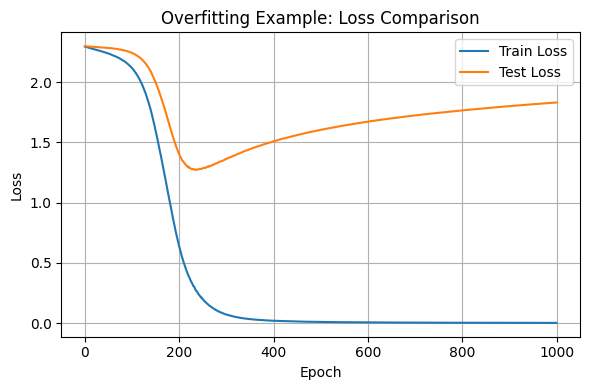

In [10]:
# 모델 생성 및 학습 준비
model = OverfitClassifier().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 모델 학습
set_seed(42)
train_losses, test_losses = train_eval(model, optimizer, small_train_loader, small_test_loader, epochs=1000)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Overfitting Example: Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

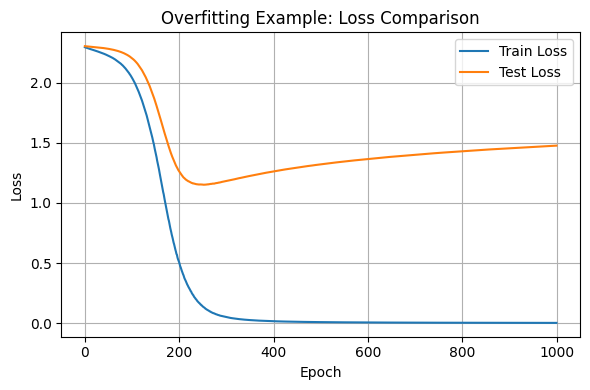

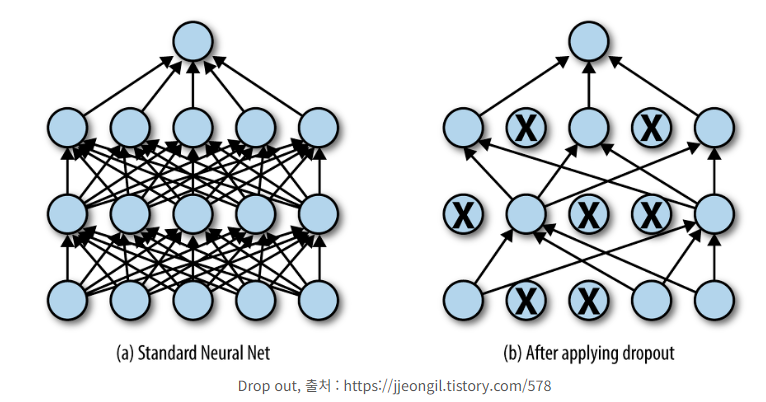

- **Regularization** : Overfitting, 즉 모델의 과도한 학습을 방지하기 위한 방법들

- **Early Stopping** : Test Loss가 증가하는 시점에서 모델의 학습을 중단하여 학습 횟수를 줄이고 과도한 학습을 방지하는 Regularization 방법

- **Dropout** : 모델의 layer에서 특정 노드들을 제거하여 연산하지 않음으로써 모델의 복잡도를 줄이는 Regularization 방법  
  - `nn.Dropout(probability)` : 일정 확률로 노드를 연산하지 않도록 함

- 너무 과한 Regularization은 학습이 아예 되지 않는 **Underfitting** 현상을 일으킬 수 있기 때문에 강도를 적절히 조절해야함


In [23]:
import torch.nn as nn

# Dropout 없는 모델
class ClassifierNoDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

# Dropout 있는 모델
class ClassifierWithDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

In [30]:
# 학습 및 평가 함수
def train_eval(model, optimizer, train_loader, test_loader, epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        # 학습
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # 평가
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                pred_label = pred.argmax(dim=1)
                correct += (pred_label == y).sum().item()
                total += y.size(0)
        test_accuracies.append(correct / total)

    return train_losses, test_accuracies

Training & Evaluating No Dropout model...


100%|██████████| 1000/1000 [02:50<00:00,  5.88it/s]


Training & Evaluating With Dropout model...


100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


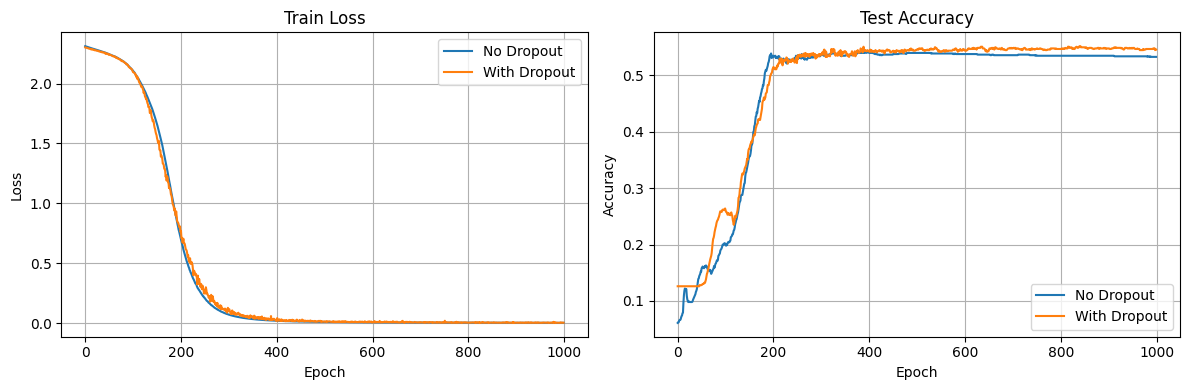

In [35]:
# 모델 생성 및 학습 준비
model_no_drop = ClassifierNoDrop().to(device)
model_with_drop = ClassifierWithDrop().to(device)

optimizer_no_drop = torch.optim.SGD(model_no_drop.parameters(), lr=0.01)
optimizer_with_drop = torch.optim.SGD(model_with_drop.parameters(), lr=0.01)

# 학습 및 평가
set_seed(42)
print("Training & Evaluating No Dropout model...")
loss_no_drop, acc_no_drop = train_eval(model_no_drop, optimizer_no_drop, small_train_loader, small_test_loader,1000)
print("Training & Evaluating With Dropout model...")
loss_with_drop, acc_with_drop = train_eval(model_with_drop, optimizer_with_drop, small_train_loader, small_test_loader,1000)

# 시각화
plt.figure(figsize=(12, 4))

# Train Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(loss_no_drop, label='No Dropout')
plt.plot(loss_with_drop, label='With Dropout')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Test Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(acc_no_drop, label='No Dropout')
plt.plot(acc_with_drop, label='With Dropout')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

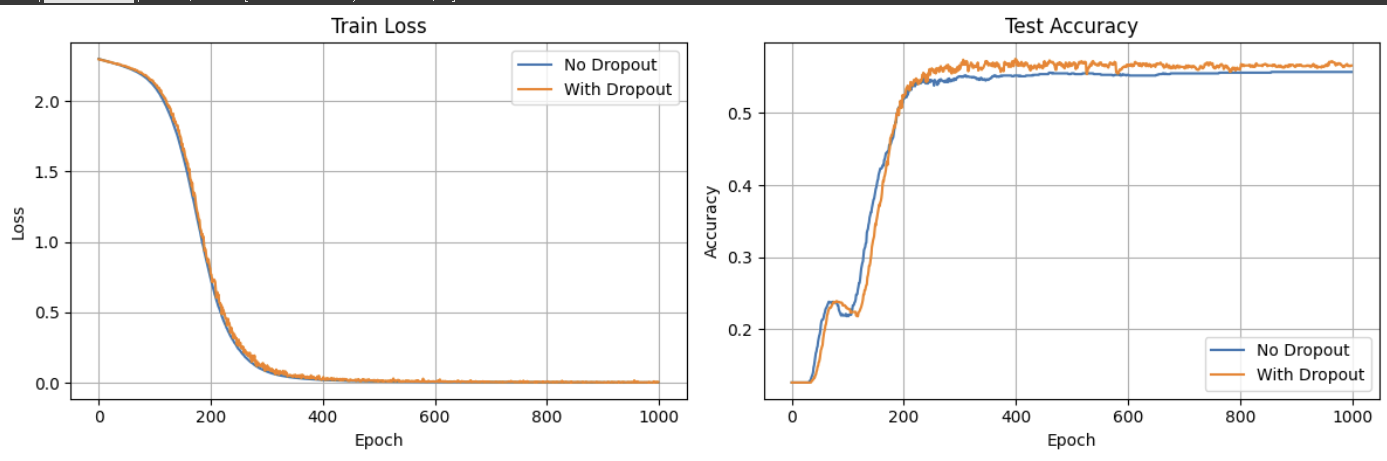

## 3. Mini-Batch Gradient Descent

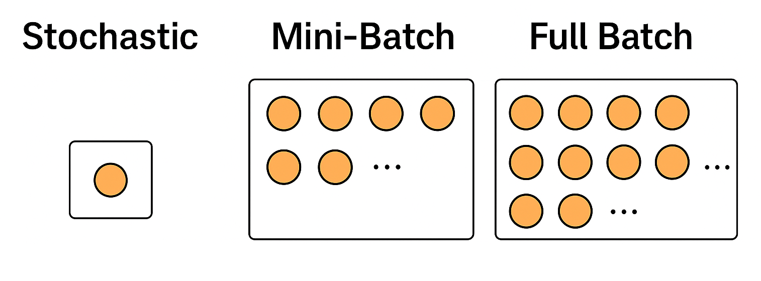

- 모델이 입력을 받을 때, 모든 데이터를 한번에 받는 것은 비효율적 (Full-Batch)
- 따라서 데이터를 뭉치로 나누어서 입력 (Mini-Batch)

- (Full) Batch Gradient Descent vs Mini-Batch Gradient Descent vs Stochastic Gradient Descent
  - (Full) Batch Gradient Descent : 데이터를 한번에 모두 입력 (비효율적)
  - Mini-Batch Gradient Descent : 데이터를 쪼개서 일부씩 입력
  - Stochastic Gradient Descent : 데이터를 한개씩 입력

- `DataLoader` 클래스를 통해 데이터를 나누어서 모델에 입력할 수 있음

      train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
      test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## 4. Momentum & Adam

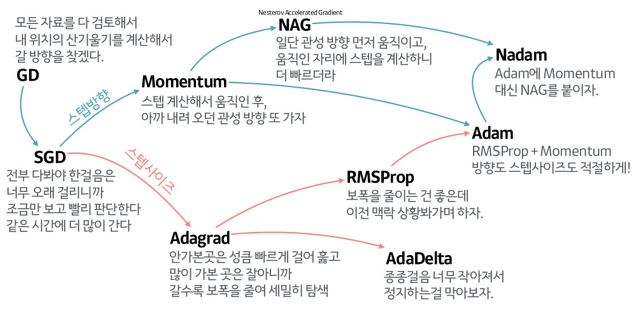

- Momentum : 과거의 Gradient를 참조하여 안정적으로 Loss Function을 최소화 하는 최적화 기법
  - `optim.SGD(model.parameter,learning rate,momentum)`
- Adam : Momentum + Weight 별로 Learning rate를 적절히 조정하여 Loss Function을 최소화 하는 최적화 기법
  - `optim.Adam(model.parameter,learning rate)`
- 이외에도 다양한 최적화 기법들이 있음

SGD vs Momentum vs Adam

In [31]:
# 모델 정의
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

Training with SGD...


100%|██████████| 10/10 [01:22<00:00,  8.20s/it]


Training with Momentum...


100%|██████████| 10/10 [01:19<00:00,  7.98s/it]


Training with Adam...


100%|██████████| 10/10 [01:21<00:00,  8.16s/it]


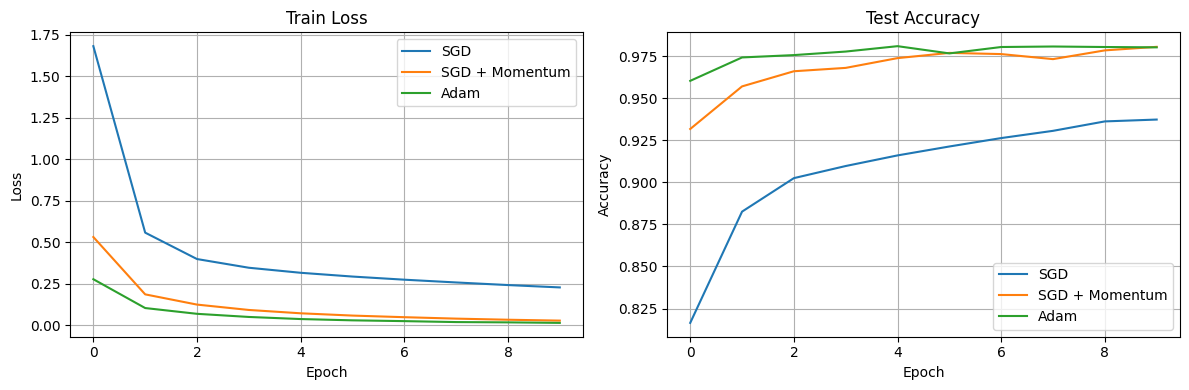

In [32]:
# 모델 생성 및 학습 준비
model_sgd = Classifier().to(device)
model_momentum = Classifier().to(device)
model_adam = Classifier().to(device)

optimizer_sgd = torch.optim.SGD(model_sgd.parameters(),lr=0.01)
optimizer_momentum = torch.optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

# 학습 및 평가
set_seed(42)
print("Training with SGD...")
loss_sgd, acc_sgd = train_eval(model_sgd, optimizer_sgd, train_loader, test_loader)

print("Training with Momentum...")
loss_momentum, acc_momentum = train_eval(model_momentum, optimizer_momentum, train_loader, test_loader)

print("Training with Adam...")
loss_adam, acc_adam = train_eval(model_adam, optimizer_adam, train_loader, test_loader)

# 시각화
plt.figure(figsize=(12, 4))

# Train Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_momentum, label='SGD + Momentum')
plt.plot(loss_adam, label='Adam')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Test Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(acc_sgd, label='SGD')
plt.plot(acc_momentum, label='SGD + Momentum')
plt.plot(acc_adam, label='Adam')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

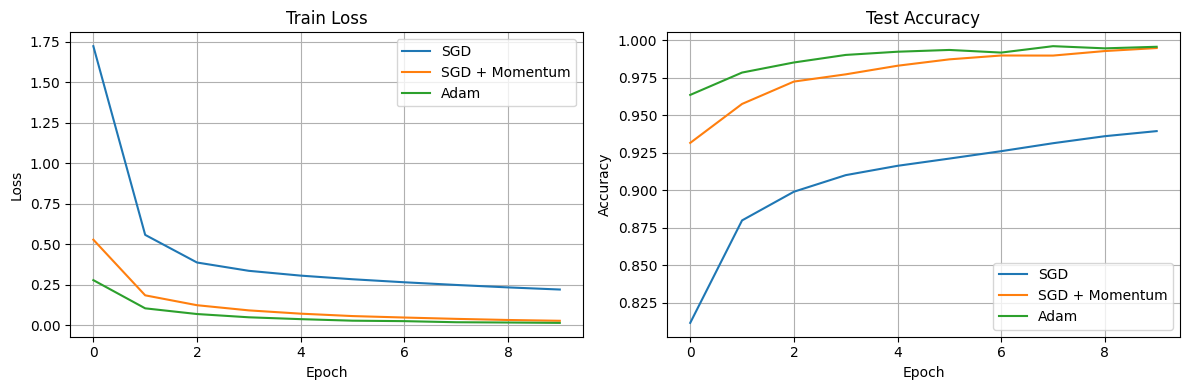

## 5. Batch Normalization

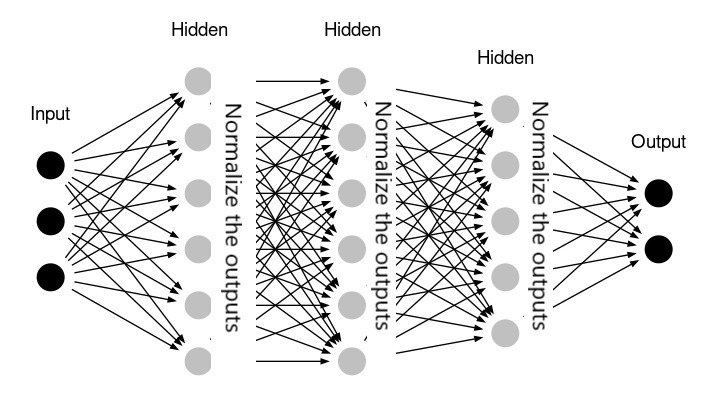

- Batch Normalization은 모델의 layer로 입력되는 값들의 분포를 항상 동일하게 유지시켜줌으로써 모델 학습을 안정화해주는 역할

- `BatchNorm1d(input_dim)` : PyTorch 에서 제공하는 Batch Normalization Layer

- Bacth Normalization 유무에 따른 성능 차이

In [33]:
import torch.nn as nn

# BN 없는 모델
class ClassifierNoBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

# BN 포함 모델
class ClassifierWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

Training & Evaluating No BN model...


100%|██████████| 10/10 [01:17<00:00,  7.75s/it]


Training & Evaluating With BN model...


100%|██████████| 10/10 [01:21<00:00,  8.10s/it]


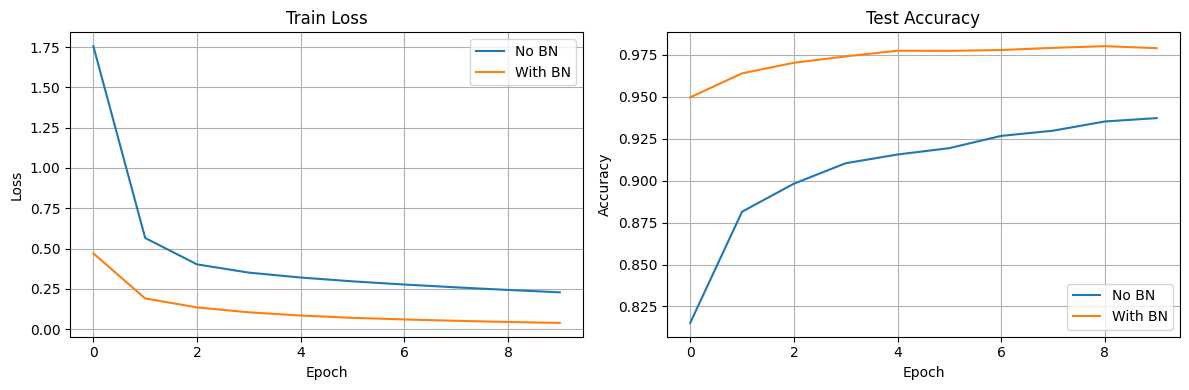

In [34]:
# 모델 생성 및 학습 준비
model_no_bn = ClassifierNoBN().to(device)
model_with_bn = ClassifierWithBN().to(device)

optimizer_no_bn = torch.optim.SGD(model_no_bn.parameters(), lr=0.01)
optimizer_with_bn = torch.optim.SGD(model_with_bn.parameters(), lr=0.01)

# 학습 및 평가
set_seed(42)
print("Training & Evaluating No BN model...")
loss_no_bn, acc_no_bn = train_eval(model_no_bn, optimizer_no_bn, train_loader, test_loader)
print("Training & Evaluating With BN model...")
loss_with_bn, acc_with_bn = train_eval(model_with_bn, optimizer_with_bn, train_loader, test_loader)

# 시각화
plt.figure(figsize=(12, 4))

# Train Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(loss_no_bn, label='No BN')
plt.plot(loss_with_bn, label='With BN')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Test Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(acc_no_bn, label='No BN')
plt.plot(acc_with_bn, label='With BN')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

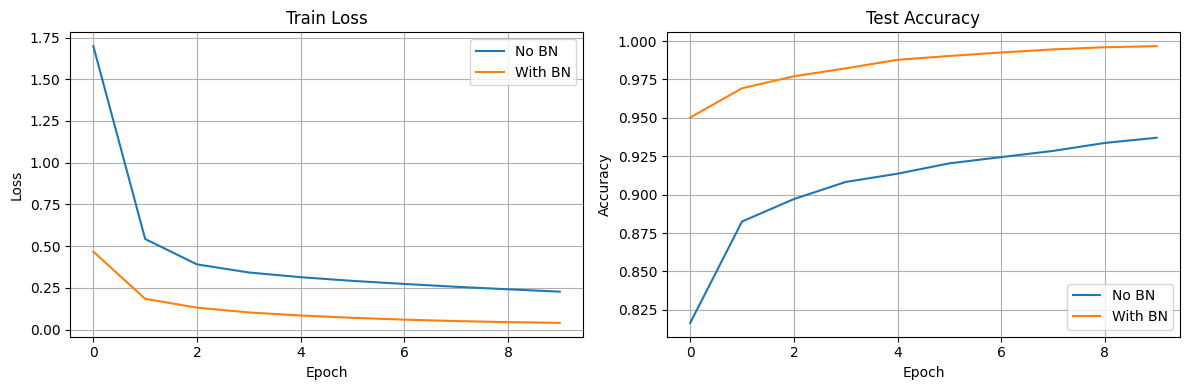